<a href="https://colab.research.google.com/github/tatianabarbone/bike-rental-prediction/blob/master/bike_rental_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook we will be predicting the number of bike rentals based on temperature, feeling temperature, humidity, wind speed and other factors.

First, we will import the relevant packages.

In [ ]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.metrics import r2_score

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


The dataset we will be using comes from the UCI ML repository, which has a ton of great ML datasets. We can easily retrieve and import the data straight into our notebook with the *wget* command.

In [ ]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00275/Bike-Sharing-Dataset.zip 
!unzip Bike-Sharing-Dataset.zip 
!ls

--2020-07-26 03:07:10--  https://archive.ics.uci.edu/ml/machine-learning-databases/00275/Bike-Sharing-Dataset.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 279992 (273K) [application/x-httpd-php]
Saving to: ‘Bike-Sharing-Dataset.zip’

Bike-Sharing-Datase 100%[===================>] 273.43K   526KB/s    in 0.5s    

2020-07-26 03:07:11 (526 KB/s) - ‘Bike-Sharing-Dataset.zip’ saved [279992/279992]

Archive:  Bike-Sharing-Dataset.zip
  inflating: Readme.txt              
  inflating: day.csv                 
  inflating: hour.csv                
Bike-Sharing-Dataset.zip  day.csv  hour.csv  Readme.txt  sample_data


Let's take a look at the format of our data.

In [ ]:
df = pd.read_csv("day.csv")
df.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


Next, we will generate descriptive statistics by calling the *describe()* method on our dataset.
These stats summarize the central tendency, dispersion and shape of our dataset’s distribution.

*   Note: temp, atemp, hum and windspeed are normalized.



In [ ]:
#get descriptive stats of the dataset
df.describe()

,instant,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000
mean,366.000000,2.496580,0.500684,6.519836,0.028728,2.997264,0.683995,1.395349,0.495385,0.474354,0.627894,0.190486,848.176471,3656.172367,4504.348837
std,211.165812,1.110807,0.500342,3.451913,0.167155,2.004787,0.465233,0.544894,0.183051,0.162961,0.142429,0.077498,686.622488,1560.256377,1937.211452
min,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.059130,0.079070,0.000000,0.022392,2.000000,20.000000,22.000000
25%,183.500000,2.000000,0.000000,4.000000,0.000000,1.000000,0.000000,1.000000,0.337083,0.337842,0.520000,0.134950,315.500000,2497.000000,3152.000000
50%,366.000000,3.000000,1.000000,7.000000,0.000000,3.000000,1.000000,1.000000,0.498333,0.486733,0.626667,0.180975,713.000000,3662.000000,4548.000000
75%,548.500000,3.000000,1.000000,10.000000,0.000000,5.000000,1.000000,2.000000,0.655417,0.608602,0.730209,0.233214,1096.000000,4776.500000,5956.000000
max,731.000000,4.000000,1.000000,12.000000,1.000000,6.000000,1.000000,3.000000,0.861667,0.840896,0.972500,0.507463,3410.000000,6946.000000,8714.000000


Seeing this in tabular form is useful, but using seaborn we'll be able to get an even clearer visualization of the shape and distribution. We'll plot a histogram of rental counts.

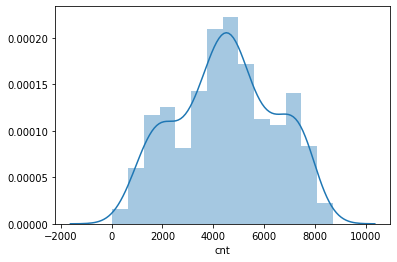

In [ ]:
count = df['cnt']
count = sns.distplot(count)

What a beautiful trimodal histogram.

We will begin by checking if the relationship between one of the independent variables, temperature, and the rental count is approximately linear. If it is, we'll be able to start making a prediction.

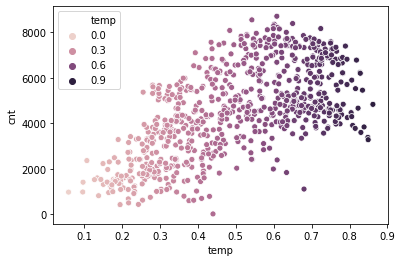

In [ ]:
sns.scatterplot(x="temp", y="cnt", hue='temp', data=df)

We can see that as the temperature increases, the rental count usually increases.

*   As an aside, it looks like as the temperature gets too hot (over 0.8*41 = 32.8 degrees C) the number of rentals starts to decline. This matches our intuition.

Next we will divide the data into features and label. Our label is what we are trying to predict (the count of bike rentals on a given day), and our features are our input into that prediction (temperature, feeling temperature, humidity and wind speed). I included all of the following attributes so that the model can have the most accurate predictions. See the Readme.txt in the zip file for a detailed description of each feature.

In [ ]:
X = df[['temp', 'atemp', 'hum', 'windspeed', 'season', 'weekday', 'workingday', 'weathersit', 'holiday']]

y = df['cnt']

There is a trade-off to consider when splitting our dataset. With less training data, our attributes will have greater variance. With less testing data, our bike count will have greater variance. By splitting the data into 70% for training and 30% for testing, we make the appropriate decision given the size of the data.

In [ ]:
# Split data into train and test set: 70% / 30%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# Create and train the model
reg = LinearRegression()
reg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

Our regression model is able to find the most impactful coefficients for each feature that we provide. We will create a special coefficient dataframe from our features by getting the *coef_* attribute of our regression model.

In [ ]:
coeff_df = pd.DataFrame(reg.coef_, X.columns, columns=['Coefficient'])
coeff_df

,Coefficient
temp,4036.295568
atemp,1761.030410
hum,-2759.251478
windspeed,-4371.389318
season,419.101650
weekday,44.077399
workingday,75.206623
weathersit,-247.910595
holiday,-535.883504


Our coefficient dataframe above tells us that windspeed has the strongest effect on the number of bike rentals, followed by temperature and humidity. This matches our intuition. Weekday and workday have the least effect.

We can interpret the temperature coefficient as the following: 

*   For every one normalized unit of increase in temperature, the change in the amount of bike rentals is approx. 4036%. In other words, for every 0.1*41 = 4.1 degrees C increase in temperature, the number of bike rentals is expected to increase by 4036 / 41= 98.4.


Let's call the *predict()* method on our model and compare how close our prediction comes to the actual data.

In [ ]:
#Make predictions 
y_pred = reg.predict(X_test)

df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df

,Actual,Predicted
196,5923,6009.642660
187,4592,6369.943763
14,1248,2864.882637
31,1360,2118.832715
390,4075,3101.664407
...,...,...
391,3456,2487.674266
571,8173,6694.624586
306,3974,4872.798698
200,4332,6549.818088


To evaluate how well our model performed, we'll look at three metrics:


*   MAE: the average of all absolute errors.
*   MSE: takes the distance of all points from the regression line (residuals) and returns the squared average.
*   RMSE: the standard deviation of the residuals.





In [ ]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 1250.891038326956
Mean Squared Error: 2091325.954010735
Root Mean Squared Error: 1446.1417475513024


Our model did a decent job at predicting rental counts, since the minimum number of rentals was 22 and the maximum was 8714.

It could have been more accurate if:

*   We had more data.
*   Our data had a more "linear" relationship.
*   We had features that had a higher correlation to the label.



We can determine how well the regression model fits the observed data with the r-squared value. R-squared is a value between 0 and 1, with a higher r-squred value generally indicating a better fit. We will round to two decimal places.

In [ ]:
print('Coefficient of determination: %.2f'
      % r2_score(y_test, y_pred))

Coefficient of determination: 0.49


Our r-squared value is 0.49, which means that our model explains 49% of the differences between the actual rental count and the predicted count. It is important to note that this number does not provide any information on the correctness of our model, but it is helpful to see the goodness-of-fit.